In [1]:
#Generic Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,re
import random
from PIL import Image 

# TensorFlow / Keras Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, Conv1D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
#Plotting Libraries
import matplotlib.pyplot as plt

#SKLearn Libraries
from sklearn.model_selection import train_test_split



2023-07-04 03:54:37.190693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
!ls Dataset/train

alpha_trace  Null


In [2]:
train_images = "Dataset/train"
test_images = "Dataset/test"

In [3]:
image_size = (180, 180)
batch_size = 10

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_images,
    #validation_split=0,
    #subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 936 files belonging to 2 classes.


2023-07-04 03:54:53.517303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


['Null', 'alpha_trace']

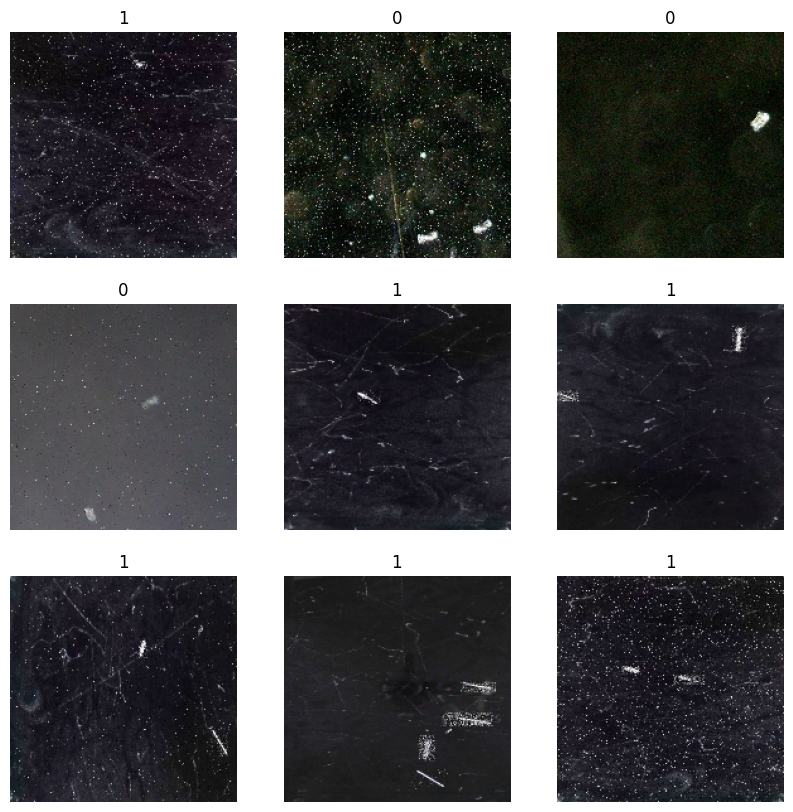

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [17]:
data = []
labels = []

for images, batch_labels in train_ds:
    data.append(images)
    labels.append(batch_labels)

data = tf.concat(data, axis=0)
labels = tf.concat(labels, axis=0)

In [18]:
normalized_data = data / 255.0

In [20]:
labels.shape, normalized_data.shape

(TensorShape([936]), TensorShape([936, 180, 180, 3]))

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [5]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (1, 1), activation='relu', input_shape=(180,180,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(32, kernel_size=(1,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation = 'softmax'))

In [11]:
# Compile the network
x = inputs = Input(shape=(180, 180,3))
x = Conv1D(
    filters=50,
    kernel_size=4,
    strides=2,
    activation="relu",
)(x)
x = Conv1D(filters=50, kernel_size=4,strides=1, activation="relu")(x)
#x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dense(10, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [6]:
epochs = 25

callbacks = [
    keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    verbose=0,
    mode="min")
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [22]:
history = model.fit(
    normalized_data, labels,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/25
30/30 [==============================] - 13s 439ms/step - loss: 0.0311 - accuracy: 0.9038
Epoch 2/25
30/30 [==============================] - 13s 446ms/step - loss: 0.0117 - accuracy: 0.9038
Epoch 3/25
30/30 [==============================] - 13s 446ms/step - loss: 0.0014 - accuracy: 0.9038
Epoch 4/25
30/30 [==============================] - 13s 432ms/step - loss: 6.2830e-05 - accuracy: 0.9038
Epoch 5/25
30/30 [==============================] - 13s 440ms/step - loss: 2.8900e-05 - accuracy: 0.9038
Epoch 6/25
30/30 [==============================] - 13s 445ms/step - loss: 3.9021e-05 - accuracy: 0.9038
Epoch 7/25
30/30 [==============================] - 13s 445ms/step - loss: 1.2510e-05 - accuracy: 0.9038
Epoch 8/25
30/30 [==============================] - 13s 429ms/step - loss: 6.4052e-05 - accuracy: 0.9038
Epoch 9/25
30/30 [==============================] - 14s 464ms/step - loss: 7.9000e-06 - accuracy: 0.9038
Epoch 10/25
30/30 [==============================] - 14s 459ms/step

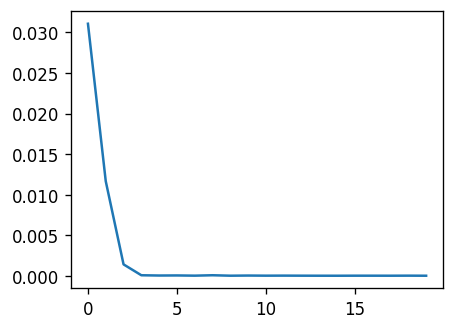

In [23]:
plt.figure(figsize=(4,3), dpi=120)
plt.plot(history.history['loss'], label = 'Train')

In [24]:
img = keras.utils.load_img("/uscms/home/rmarroqu/nobackup/AI4PID/Dataset/test/Null/roti_0011_jpg.rf.33598e0e863c45a4e6907367ed496da2.jpg", target_size=image_size)

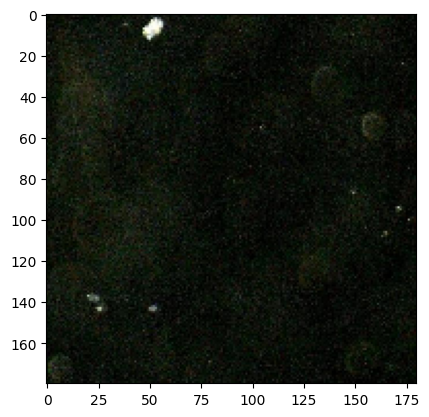

In [25]:
img_array = keras.utils.img_to_array(img)
plt.imshow(img_array.astype("uint8"))

In [26]:
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [27]:
predictions = model.predict(img_array) #probability to predict class 1
score = float(predictions[0])

1/1 [==============================] - 0s 32ms/step


/tmp/ipykernel_15184/3661298999.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


In [28]:
train_ds.class_names

['Null', 'alpha_trace']

In [29]:
print(f"This image is {100 * (1 - score):.2f}% {train_ds.class_names[0]} \
and {100 * score:.2f}% {train_ds.class_names[1]}")

This image is 0.00% Null and 100.00% alpha_trace


In [30]:
score

1.0